In [1]:
# Import my code
#from tensorfactorization.poisson import *
from tensorfactorization.multiplicative import *
from tensorfactorization.poisson import *

In [2]:
#%matplotlib widget
import tensorly as tl
import numpy as np
import torch
import math
import time
import random
import matplotlib.pyplot as plt
from skimage import data

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

from dataclasses import dataclass, field
from typing import List

import copy # import copy so that we can do deep copys

import pickle # use pickle to save results to disk

In [3]:
def random_cp_with_noise(dimensions, F, noise_scaling=0.1, context={}):
    """
    Create a random CP tensor with some added noise
    """
    true_solution = tl.random.random_cp(dimensions, F, full=True, **context)
    noise = tl.random.random_tensor(dimensions, **context) * noise_scaling * tl.max(true_solution)
    X = true_solution + noise
    return X

In [4]:
def create_initial_data(X, F):
    """
    Create random initial A_ns for our algorithms
    """
    N = X.ndim # get dimension of X
    X_shape = X.shape
    # initialize A_j with random positive values if it was not given
    A_ns = []
    for i in range(N):
        # we use random.random_tensor as it returns a tensor
        A_ns.append(tl.random.random_tensor((X_shape[i], F), **tl.context(X)))
    return A_ns

# Testing Geometric Poisson Algorithm

In [5]:
# first test numpy backend
tl.set_backend('numpy')

tensor = random_cp_with_noise((10, 10, 10), 2)
print(tl.context(tensor))

{'dtype': dtype('float64')}


C:\Users\David\.conda\envs\tensor_factorization\lib\site-packages\tensorly\backend\__init__.py:206: RuntimeWarning: overflow encountered in exp
  return getattr(



 
 Update_approximation_everytime = False 
 

took 5.6360015869140625 seconds with final error 0.18006260102895558

 
 Update_approximation_everytime = True 
 

took 6.131999492645264 seconds with final error 0.1465261224953962


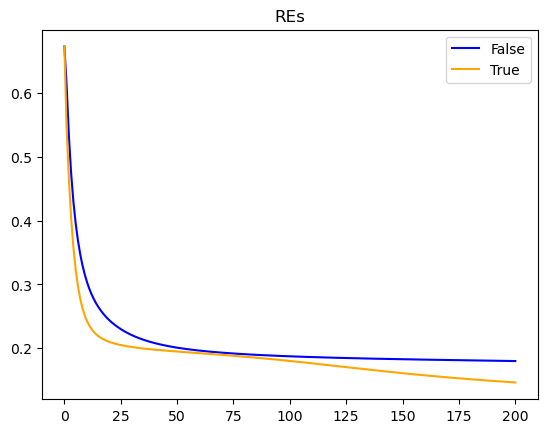

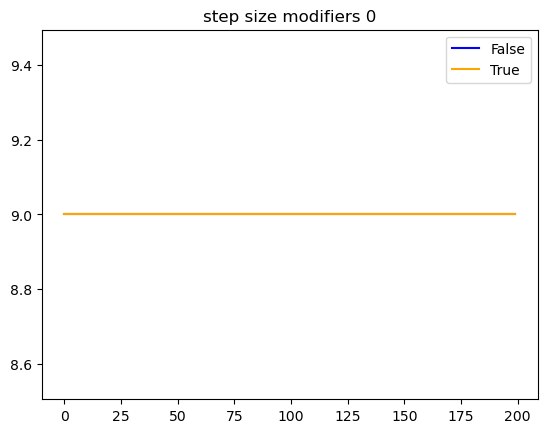

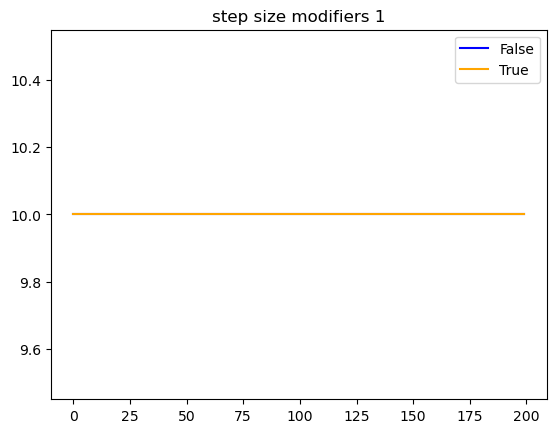

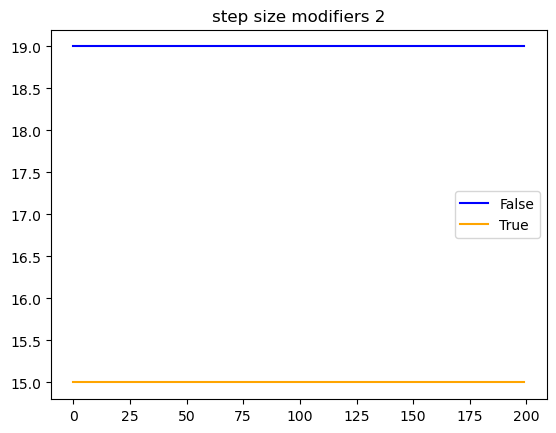

In [5]:
# first lets compare update_approximation_everytime
dimension = (300, 300, 3)
F = 3
max_iter = 200
verbose = False

tensor = random_cp_with_noise(dimension, F)
# create initial data for both
initial_A_ns = create_initial_data(tensor, F)

# Without update_approximation_everytime
start = time.time()
_, RE_false, approx_false, step_size_modifiers_false = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=verbose, update_approximation_everytime=False, initial_A_ns=initial_A_ns)
end = time.time()
time_false = end - start
print("\n \n Update_approximation_everytime = False \n \n")
print("took " + str(time_false) + " seconds with final error " + str(RE_false[-1]))

# with update_approximation_everytime
start = time.time()
_, RE_true, approx_true, step_size_modifiers_true = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=verbose, update_approximation_everytime=True, initial_A_ns=initial_A_ns)
end = time.time()
time_true = end - start
print("\n \n Update_approximation_everytime = True \n \n")
print("took " + str(time_true) + " seconds with final error " + str(RE_true[-1]))


plt.plot(RE_false, label="False", color="blue")
plt.plot(RE_true, label="True", color="orange")
plt.title("REs")
plt.legend()
plt.show()

for n in range(F):
    plt.plot(step_size_modifiers_false[n], label="False", color="blue")
    plt.plot(step_size_modifiers_true[n], label="True", color="orange")
    plt.title("step size modifiers " + str(n))
    plt.legend()
    plt.show()

## Plotting Iteration

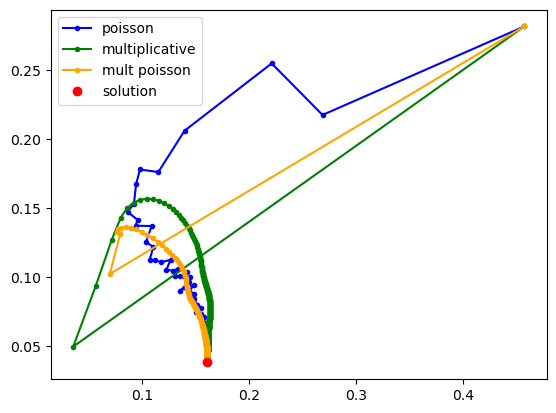

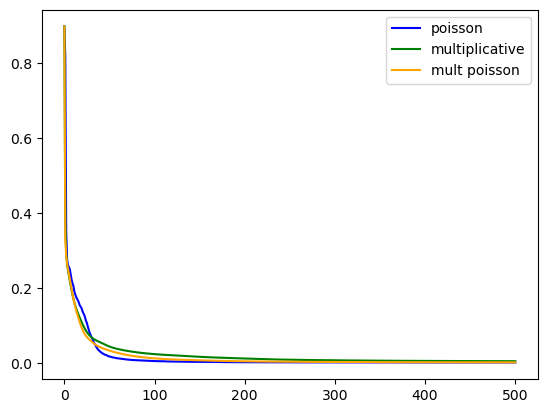

In [6]:
# plot part of the iteration by taking 2 Choords of the tensor and plotting there
tl.set_backend('numpy')
F = 3
max_iter = 500
index0 = (1, 1, 1)
index1 = (1, 1, 2)

tensor = random_cp_with_noise((100, 100, 3), F, noise_scaling=0.0)
initial_A_ns = create_initial_data(tensor, F)
A_ns_poisson = deepcopy(initial_A_ns)
A_ns_mult = deepcopy(initial_A_ns)
A_ns_mult_poisson = deepcopy(initial_A_ns)

intital_approx = defactorizing_CP(initial_A_ns, tensor.shape)

# list of tuples (index0, index1) during the iteration for the 3 algorithms
graph_poisson = [(intital_approx[index0], intital_approx[index1])] 
graph_mult = [(intital_approx[index0], intital_approx[index1])]
graph_mult_poisson = [(intital_approx[index0], intital_approx[index1])]

RE_poisson = [tl.norm(tensor - defactorizing_CP(initial_A_ns, tensor.shape)) / tl.norm(tensor)]
RE_mult = [tl.norm(tensor - defactorizing_CP(initial_A_ns, tensor.shape)) / tl.norm(tensor)]
RE_mult_poisson = [tl.norm(tensor - defactorizing_CP(initial_A_ns, tensor.shape)) / tl.norm(tensor)]

# achive this by always doing one iteration step from each algorithm
for i in range(max_iter):
    # Poisson algorithm
    A_ns_poisson, RE, approx_poisson, _ = tensor_factorization_cp_poisson(tensor, F, max_iter=1, detailed=True, initial_A_ns=A_ns_poisson)
    graph_poisson.append( (approx_poisson[index0], approx_poisson[index1]) )
    RE_poisson.append(RE[-1])

    # Multiplicative algorithm
    A_ns_mult, RE, approx_mult = tensor_factorization_cp_multiplicative(tensor, F, max_iter=1, detailed=True, initial_A_ns=A_ns_mult)
    graph_mult.append( (approx_mult[index0], approx_mult[index1]) )
    RE_mult.append(RE[-1])

    # Multiplicative Poisson algorithm
    A_ns_mult_poisson, RE, approx_mult_poisson = tensor_factorization_cp_multiplicative_poisson(tensor, F, max_iter=1, detailed=True, initial_A_ns=A_ns_mult_poisson)
    graph_mult_poisson.append( (approx_mult_poisson[index0], approx_mult_poisson[index1]) )
    RE_mult_poisson.append(RE[-1])





plt.plot([e[0] for e in graph_poisson], [e[1] for e in graph_poisson], marker='.', label='poisson', color='blue')
plt.plot([e[0] for e in graph_mult], [e[1] for e in graph_mult], marker='.', label='multiplicative', color='green')
plt.plot([e[0] for e in graph_mult_poisson], [e[1] for e in graph_mult_poisson], marker='.', label='mult poisson', color='orange')
# plot true solution
plt.plot(tensor[index0], tensor[index1], 'o', label='solution', color='red')
plt.legend()
plt.show()


plt.plot(RE_poisson, label='poisson', color='blue')
plt.plot(RE_mult, label='multiplicative', color='green')
plt.plot(RE_mult_poisson, label='mult poisson', color='orange')
plt.legend()
plt.show()

tensor([[0.0568, 0.1574, 0.1200, 0.1485, 0.0798, 0.0809, 0.2373, 0.1802, 0.0558,
         0.1099],
        [0.1199, 0.4109, 0.3104, 0.3940, 0.2676, 0.1877, 0.5350, 0.3403, 0.1562,
         0.3345],
        [0.1499, 0.2869, 0.1462, 0.2750, 0.1609, 0.1572, 0.3706, 0.2505, 0.1426,
         0.2375],
        [0.1186, 0.2517, 0.0995, 0.1635, 0.2600, 0.1987, 0.2914, 0.1810, 0.2220,
         0.1709],
        [0.1209, 0.3472, 0.0975, 0.2573, 0.3900, 0.2672, 0.3914, 0.2609, 0.3195,
         0.1721],
        [0.0775, 0.1475, 0.0770, 0.1440, 0.1087, 0.1313, 0.1327, 0.0931, 0.1348,
         0.0678],
        [0.1190, 0.2820, 0.1449, 0.2837, 0.2415, 0.1588, 0.3962, 0.2099, 0.1876,
         0.1953],
        [0.1036, 0.4361, 0.2557, 0.3574, 0.3988, 0.2273, 0.5175, 0.3236, 0.2856,
         0.3085],
        [0.1405, 0.2680, 0.2104, 0.2301, 0.1331, 0.1181, 0.4029, 0.2485, 0.0839,
         0.2134],
        [0.1093, 0.2989, 0.1584, 0.2138, 0.2378, 0.1859, 0.2764, 0.1892, 0.2250,
         0.1843]], device='c

Time for my implementation is: 0.0018736057565114756 seconds, in 269 iterations
Time for my implementation is: 0.0017674457195193268 seconds, in 215 iterations
Time for Tensorly implementation is: 0.002545050797032696 seconds, in 233 iterations


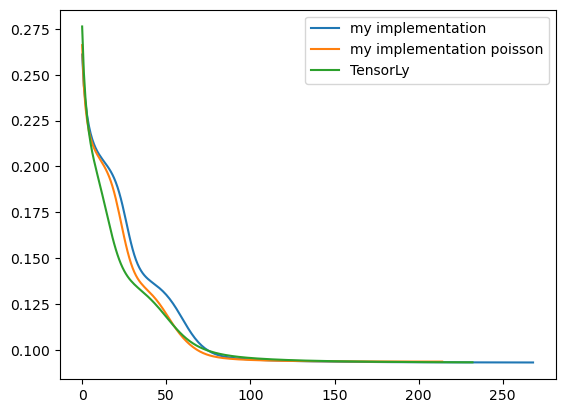

In [44]:
# comparing my multiplicative and TensorLys, as they are the same algorithm
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}
X = random_cp_with_noise((300, 300, 3), 3, context=context)
F = 3

# first check my implementation
start = time.time()
_, RE_mult, approx_mult = tensor_factorization_cp_multiplicative(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
RE_mult.pop(0)
print("Time for my implementation is: " + str((end-start)/len(RE_mult)) + " seconds, in " + str(len(RE_mult)) + " iterations")

# first check my implementation for poisson
start = time.time()
_, RE_mult_poisson, approx_mult_poisson = tensor_factorization_cp_multiplicative_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
RE_mult_poisson.pop(0)
print("Time for my implementation is: " + str((end-start)/len(RE_mult_poisson)) + " seconds, in " + str(len(RE_mult_poisson)) + " iterations")

# TensorLy
start = time.time()
_, RE_tensorly = tl.decomposition.non_negative_parafac(X, F, init='random', n_iter_max=1000, return_errors=True)
end = time.time()
print("Time for Tensorly implementation is: " + str((end-start)/len(RE_tensorly)) + " seconds, in " + str(len(RE_tensorly)) + " iterations")

plt.plot([value.cpu() for value in RE_mult], label="my implementation")
plt.plot([value.cpu() for value in RE_mult_poisson], label="my implementation poisson")
plt.plot([value.cpu() for value in RE_tensorly], label="TensorLy")
plt.legend()
plt.show()

In [3]:
x = np.array([1.0, 2.0, 3.0, 4.0])
G = np.diag(1.0/x)
G_inv = np.diag(x)
print(G_inv)
dF = np.array([1.0, 2.0, 3.0, 4.0])
print(np.sum(dF * G_inv@dF))
print(np.sum(dF * x * dF))

A = np.random.rand(2,3)
dF = np.random.rand(2, 3)
print(tl.sum(dF * A * dF))
#print(
step_size_modifiers = []
for i in range(3):
    step_size_modifiers.append([])
print(step_size_modifiers)

[[1. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 3. 0.]
 [0. 0. 0. 4.]]
100.0
100.0
0.5868339027092577
[[], [], []]


In [4]:
tensor = tl.random.random_tensor((10, 10))
tl.context(tensor)
tl.set_backend('pytorch')
print(tl.get_backend())
torch.cuda.is_available()

pytorch


True

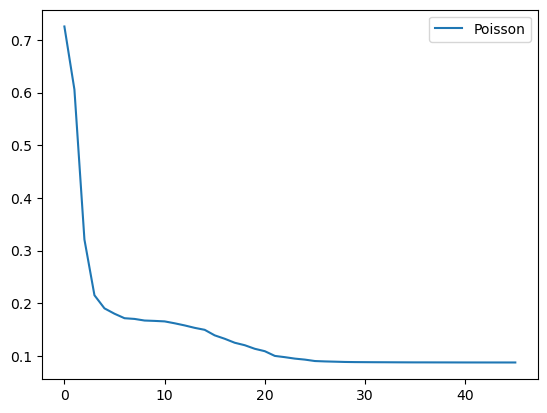

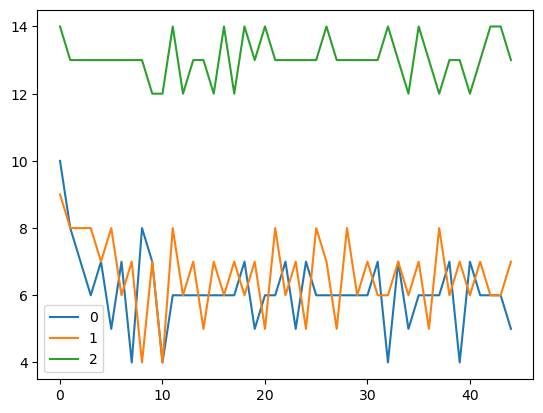

In [14]:
# Testing just poisson algo
tl.set_backend('numpy')
dimensions = (300, 300, 3)
F = 2
noise_scaling = 0.1
true_solution = tl.random.random_cp(dimensions, F, full=True)
noise = tl.random.random_tensor(dimensions) * noise_scaling * tl.max(true_solution)
X = true_solution + noise

start = time.time()
A_ns, RE_poisson, approx_poisson, step_size_modifiers = tensor_factorization_cp_poisson(X, F, max_iter=100, detailed=True, verbose=False)
end = time.time()
plt.plot(RE_poisson, label="Poisson")
plt.legend()
plt.show()

for n, modifiers in enumerate(step_size_modifiers):
    plt.plot(modifiers, label=n)
plt.legend()
plt.show()

Poisson algorithm took 30.702001333236694 seconds with 1001 iterations and had final error of 46.36139668840612
Multiplicative algorithm took 5.866997480392456 seconds with 874 iterations and had final error of 37.71091722195715
Multiplicative Poisson algorithm took 7.145000219345093 seconds with 589 iterations and had final error of 37.7919766393004
Muliplicative algorithm was 5.233000599683737 times faster in total
Muliplicative algorithm was 4.568409523523902 times faster per iteration
Muliplicative Poisson algorithm was 2.5266306829585914 times faster per iteration


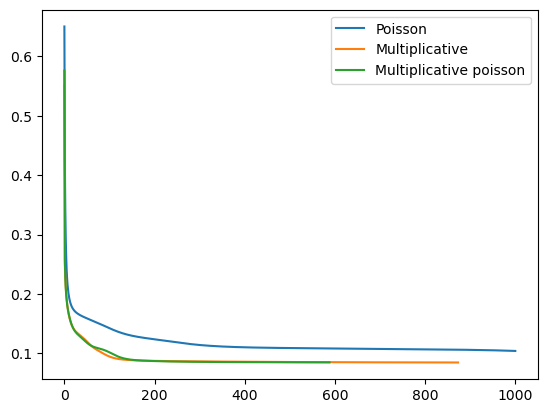

In [7]:
# Comparing on CPU
tl.set_backend('numpy')
dimensions = (300, 300, 3)
F = 4
noise_scaling = 0.1
true_solution = tl.random.random_cp(dimensions, F, full=True)
noise = tl.random.random_tensor(dimensions) * noise_scaling * tl.max(true_solution)
X = true_solution + noise
#A = tl.eye(4)
#print(A)
start = time.time()
_, RE_poisson, approx_poisson, _ = tensor_factorization_cp_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_poisson = end - start
start = time.time()
_, RE_mult, approx_mult = tensor_factorization_cp_multiplicative(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative = end - start
start = time.time()
_, RE_mult_poisson, approx_mult_poisson = tensor_factorization_cp_multiplicative_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative_poisson = end - start
print("Poisson algorithm took " + str(time_poisson) + " seconds with " + str(len(RE_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_poisson)))
print("Multiplicative algorithm took " + str(time_multiplicative) + " seconds with " + str(len(RE_mult)) + " iterations and had final error of " + str(tl.norm(X - approx_mult)))
print("Multiplicative Poisson algorithm took " + str(time_multiplicative_poisson) + " seconds with " + str(len(RE_mult_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_mult_poisson)))
print("Muliplicative algorithm was " + str(time_poisson/time_multiplicative) + " times faster in total")
time_per_iteration_poisson = time_poisson / (len(RE_poisson) - 1)
time_per_iteration_mult = time_multiplicative / (len(RE_mult) - 1)
time_per_iteration_mult_poisson = time_multiplicative_poisson / (len(RE_mult_poisson) - 1)
print("Muliplicative algorithm was " + str(time_per_iteration_poisson/time_per_iteration_mult) + " times faster per iteration")
print("Muliplicative Poisson algorithm was " + str(time_per_iteration_poisson/time_per_iteration_mult_poisson) + " times faster per iteration")
#print(tl.norm(A-tl.random.random_cp((4, 4, 4), 2, full=True)))
#plt.figure()
plt.plot(RE_poisson, label="Poisson")
plt.plot(RE_mult, label="Multiplicative")
plt.plot(RE_mult_poisson, label="Multiplicative poisson")
plt.legend()
plt.show()

Poisson algorithm took 1.1200237274169922 seconds with 150 iterations and had final error of tensor(28.5928, device='cuda:0')
Multiplicative algorithm took 0.3459770679473877 seconds with 388 iterations and had final error of tensor(26.9898, device='cuda:0')
Multiplicative Poisson algorithm took 0.2369999885559082 seconds with 175 iterations and had final error of tensor(28.5673, device='cuda:0')
Muliplicative algorithm was 3.2372773550046756 times faster in total
Muliplicative algorithm was 8.408230445549057 times faster per iteration


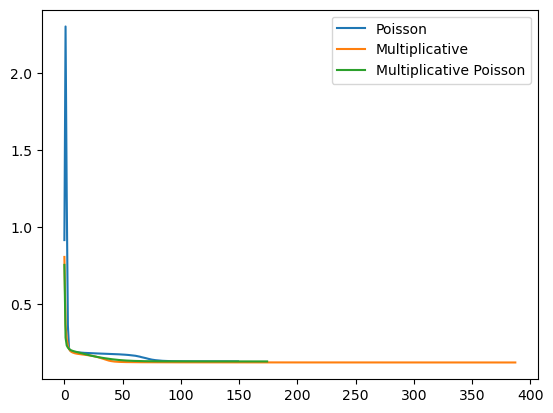

In [5]:
# Comparing on GPU with pytorch
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}
dimensions = (300, 300, 3)
F = 2
noise_scaling = 0.1
true_solution = tl.random.random_cp(dimensions, F, full=True, **context)
noise = tl.random.random_tensor(dimensions, **context) * noise_scaling * tl.max(true_solution)
X = true_solution + noise
#A = tl.eye(4)
#print(A)
start = time.time()
_, RE_poisson, approx_poisson, _ = tensor_factorization_cp_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_poisson = end - start
start = time.time()
_, RE_mult, approx_mult = tensor_factorization_cp_multiplicative(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative = end - start
start = time.time()
_, RE_mult_poisson, approx_mult_poisson = tensor_factorization_cp_multiplicative_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative_poisson = end - start
print("Poisson algorithm took " + str(time_poisson) + " seconds with " + str(len(RE_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_poisson)))
print("Multiplicative algorithm took " + str(time_multiplicative) + " seconds with " + str(len(RE_mult)) + " iterations and had final error of " + str(tl.norm(X - approx_mult)))
print("Multiplicative Poisson algorithm took " + str(time_multiplicative_poisson) + " seconds with " + str(len(RE_mult_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_mult_poisson)))
print("Muliplicative algorithm was " + str(time_poisson/time_multiplicative) + " times faster in total")
time_per_iteration_poisson = time_poisson / (len(RE_poisson) - 1)
time_per_iteration_mult = time_multiplicative / (len(RE_mult) - 1)
print("Muliplicative algorithm was " + str(time_per_iteration_poisson/time_per_iteration_mult) + " times faster per iteration")

plt.plot([value.cpu() for value in RE_poisson], label="Poisson")
plt.plot([value.cpu() for value in RE_mult], label="Multiplicative")
plt.plot([value.cpu() for value in RE_mult_poisson], label="Multiplicative Poisson")
plt.legend()
plt.show()

In [12]:
# comparing sqrt and exp

tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}

tensor = random_cp_with_noise((300, 300, 3), 4, context=context) - 0.5*tl.ones((300, 300, 3), **context)
A_ns = create_initial_data(tensor, 4)
beta = 0.5
alpha = 0.5

m = 1
N = 1000

exponential = tl.exp( math.pow(beta, m) * alpha * tensor)

# time recalculating exp
start = time.time()
m += 1
for i in range(N):
    update_exp =  tl.exp( math.pow(beta, m) * alpha * tensor)
end = time.time()
time_exp = end-start

# recalc using sqrt
start = time.time()
for i in range(N):
    update_sqrt = tl.sqrt(exponential)
end = time.time()
time_sqrt = end-start

print("time exponential = " + str(time_exp))
print("time sqrt = " + str(time_sqrt))

print("Difference in tensors = " + str(tl.max(tl.abs(update_exp - update_sqrt))))


# timing calculation speed of f
for n in range(3):
    start = time.time()
    khatri_rao_product = tl.tenalg.khatri_rao(A_ns, skip_matrix=n)
    f = lambda A: tl.sum( tl.matmul(A, tl.transpose(khatri_rao_product)) - tl.base.unfold(tensor, n) * tl.log( tl.matmul(A, tl.transpose(khatri_rao_product)) ))
    end = time.time()
    time_initialsetup = end - start
    start = time.time()
    for i in range(N):
        blob = f(A_ns[n])
    end = time.time()
    time_f = end-start
    # lets also check time for updating A_ns
    for i in range(N):
        blob = tl.exp(10.3*A_ns[n])
    end = time.time()
    time_exp = end - end
    # check time for khatri rao time A_n
    start = time.time()
    for i in range(N):
        blob = tl.matmul(A_ns[n], tl.transpose(khatri_rao_product))
    end = time.time()
    time_khatri_rao_prod = end-start
    # check time for logarithm
    start = time.time()
    for i in range(N):
        nope = tl.log(blob)
    end = time.time()
    time_log = end-start

    print("Time for initial setup: " + str(time_initialsetup))
    print("Time for f: " + str(time_f))
    print("Time for exp: " + str(time_exp))
    print("Time for khatri rao matmul A_n: " + str(time_khatri_rao_prod))
    print("Time for logarithm: " + str(time_log))

# test time for log
start = time.time()
for i in range(N):
    blob = tl.log(tensor)
time_log = time.time() - start

print("Time for log: " + str(time_log))




time exponential = 0.017000198364257812
time sqrt = 0.006000041961669922
Difference in tensors = tensor(1.1921e-07, device='cuda:0')
Time for initial setup: 0.0
Time for f: 0.125
Time for exp: 0.0
Time for khatri rao matmul A_n: 0.020999908447265625
Time for logarithm: 0.006000041961669922
Time for initial setup: 0.0
Time for f: 0.17000079154968262
Time for exp: 0.0
Time for khatri rao matmul A_n: 0.02299952507019043
Time for logarithm: 0.005999088287353516
Time for initial setup: 0.0
Time for f: 0.1380002498626709
Time for exp: 0.0
Time for khatri rao matmul A_n: 0.02200627326965332
Time for logarithm: 0.005993843078613281
Time for log: 0.006001949310302734


In [46]:
int(3.9)

3